## Tutorial 7: Spiking Neural Networks

In [ ]:
pip install brian2

In [2]:
from brian2 import *
import matplotlib.pyplot as plt

### A simple model:
We will first implement a simple differential equation so that we can get started with defining, running, and plotting simulations in Brian. We will start by defining a parameter and the differential equation defining the model:

In [4]:
# parameters and model equations
tau = 20*ms
eqs = '''
dx/dt = -x/tau : 1
'''
# create model
N = NeuronGroup(1, eqs)

# initialize model
N.x = 0

# record model state
M = StateMonitor(N, 'x', record = True)

INFO       No numerical integration method specified for group 'neurongroup_1', using method 'exact' (took 0.02s). [brian2.stateupdaters.base.method_choice]


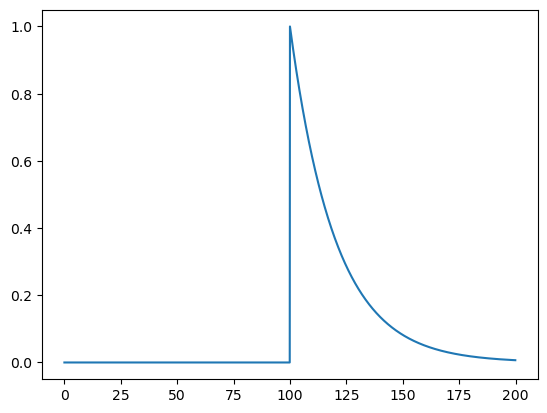

In [5]:
## We can then run the simulation for 100 milliseconds:
run(100*ms)

## and now, we will add increase the value of x to 1 and run the simulation for another 100 milliseconds:
N.x = 1
run(100*ms)

## Plotting the result which illustrates the simple decay dynamics resulting from the differential equation:
plt.plot( M.t/ms, M.x[0] )

### Spiking neural network (SNN)
Today, we will scale up our simulations from single neurons to networks. This will allow us to simulate the dynamics of the networks of neurons in a small patch of cortex, using networks of LIF neurons. We will study the spiking network simulation below:

INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.02s, trying other methods took 0.08s). [brian2.stateupdaters.base.method_choice]


Starting simulation at t=0. s for a duration of 1. s
1. s (100%) simulated in < 1s


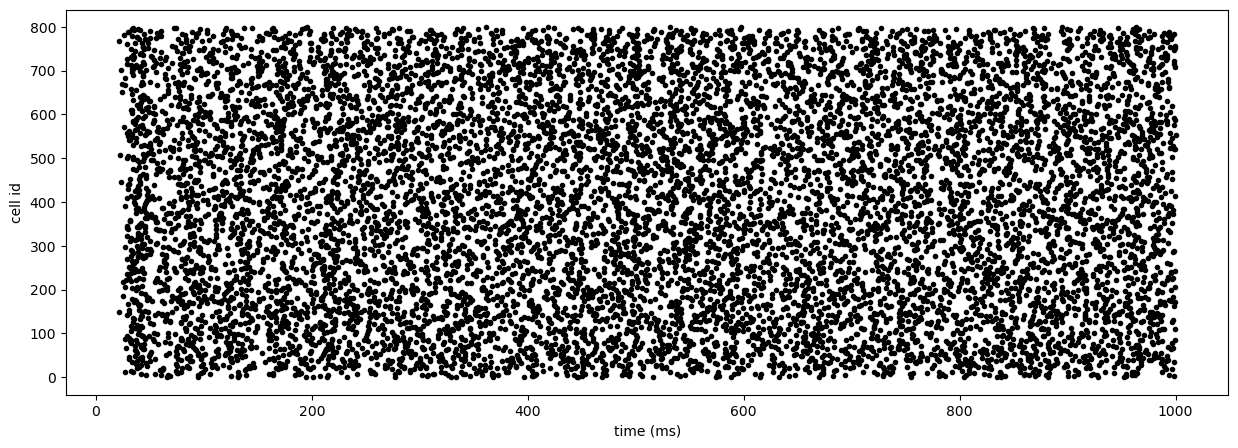

In [6]:
# network parameters
N = 1000; Ne = int( 0.8*N ); Ni = int( 0.2*N );

# membrane parameters
C = 200 * pF
taum = 20 * msecond
gL = C / taum
El = -70 * mV
Vth = -50 * mV

# synapse parameters
Ee = 0 * mvolt
Ei = -80 * mvolt
taue = 5 * msecond
taui = 5 * msecond

# excitatory and inhibitory weights
g = 4    # balance between excitation and inhibition
we = 0.5 * nS     # excitatory synaptic weight
wi = ( 7 * g * (we/nS) ) * nS    # inhibitory synaptic weight

# input parameters
input_rate = 2*Hz    # Poisson input rate

# membrane equation
eqs = Equations('''
dv/dt = ( gL*(El-v) + ge*(Ee-v) + gi*(Ei-v) ) * (1./C) : volt
dge/dt = -ge*(1./taue) : siemens
dgi/dt = -gi*(1./taui) : siemens''')

# setup network
P = NeuronGroup( N, model=eqs, threshold='v>Vth', reset='v=El', refractory=5*ms )
Pe = P[0:Ne]; Pi = P[Ne:]

# setup excitatory and inhibitory connections
Ce = Synapses( Pe, P, on_pre='ge+=we' )
Ce.connect( True, p=0.01 )
Ci = Synapses( Pi, P, on_pre='gi+=wi' )
Ci.connect( True, p=0.01 )

# setup Poisson input
Ie = PoissonInput( P, 'ge', Ne, input_rate, weight=we )

# initialize network
P.v = randn( len(P) ) * 5 * mV - 70 * mV

# record spikes + rates (excitatory population)
M = SpikeMonitor( Pe )
R = PopulationRateMonitor( Pe )

# run simulation
run( 1 * second, report='text' )

# plot spike raster
figure( figsize=(15,5) )
xlabel( 'time (ms)' ); ylabel( 'cell id' )
plot( M.t/ms, M.i, '.k' )
show()

Finally, we can study how states of regular, highly synchronous spiking emerge in the network at different values of g and input_rate. To quantify the irregularity in the network, we can calculate Cv using the code below:

In [7]:
def coefficient_of_variation( spike_monitor, N ):
    # calculate Cv of inter-spike intervals
    cv = np.zeros( N )
    for ii in range(N):
        tau = diff( spike_monitor.spike_trains()[ii] )
        cv[ii] = std( tau ) / mean( tau )